In [1]:
import os
import yaml
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import cv2
import sys
import random

os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')
sys.path.append('src')

from src.dataset import TrainingDataset

In [2]:
with open('config.yaml') as f:
    cfg = yaml.safe_load(f)
    
cfg

{'images_dir': 'data/images',
 'masks_dir': 'data/masks',
 'n_random_patches_per_image': 28,
 'patch_size': 256,
 'patch_overlap': 0.5}

In [3]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [4]:
dataset = TrainingDataset(
    image_filepaths = image_filepaths,
    mask_filepaths = mask_filepaths,
    n_random_patches_per_image = cfg['n_random_patches_per_image'],
    patch_size = cfg['patch_size']
)

## TRANSFORM PIPELINE

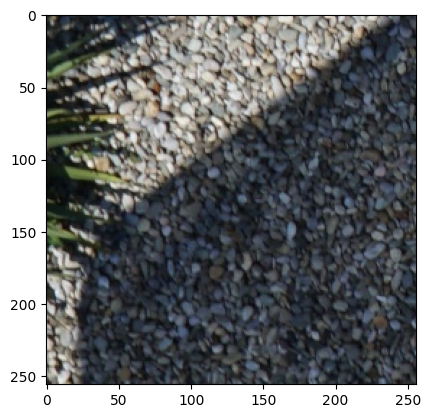

In [67]:
patch_image, patch_mask = dataset[5439]

plt.imshow(patch_image.permute(1, 2, 0))
plt.show()

0 3
tensor([0, 1, 2, 3], dtype=torch.uint8)


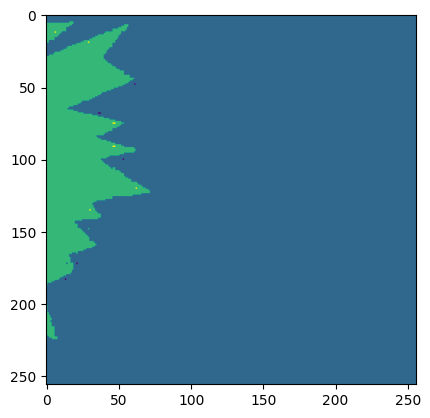

In [68]:
print(torch.min(patch_mask).item(), torch.max(patch_mask).item())
print(torch.unique(patch_mask))

plt.imshow(patch_mask)
plt.show()

In [70]:
patch_image.dtype, patch_mask.dtype

(torch.uint8, torch.uint8)

In [84]:
patch_image.shape, patch_mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [98]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5), # dual transform
    A.RandomBrightnessContrast(p=0.5), # image only transform
    A.HueSaturationValue(hue_shift_limit=100, sat_shift_limit=100, val_shift_limit=100, p=1), # image only transform
    A.RandomGamma(p=0.5), # image only transform
])

In [99]:
transformed = transforms(
    image = patch_image.numpy().transpose(1, 2, 0),  # to np.array [H, W, C]
    mask = patch_mask.numpy()
)

In [100]:
patch_image_transf = transformed['image']
patch_mask_transf = transformed['mask']

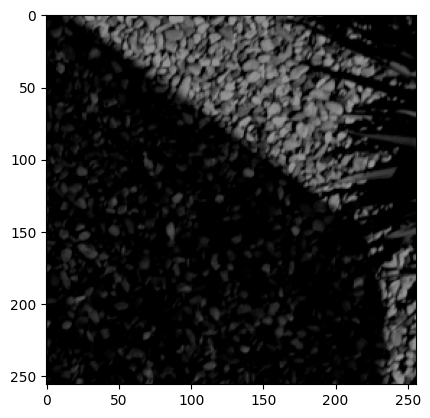

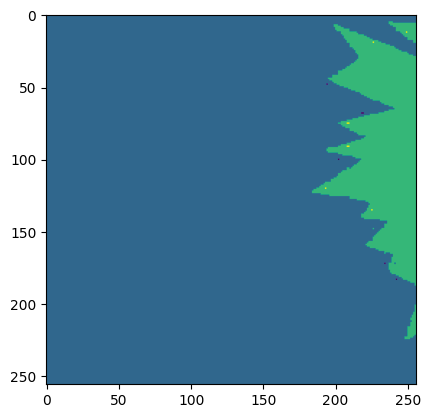

In [101]:
plt.imshow(patch_image_transf)
plt.show()

plt.imshow(patch_mask_transf)
plt.show()

In [104]:
# Check if mask pixels have been changed (they should not!)
patch_mask.sum().item(), patch_mask_transf.sum()

(72332, 72332)

- Apply Albumentation transforms to np.arrays.
- Image array must have shape [H, W, C], while mask array can have shape [H, W]. 

## TESTING SOME TRANSFORMS

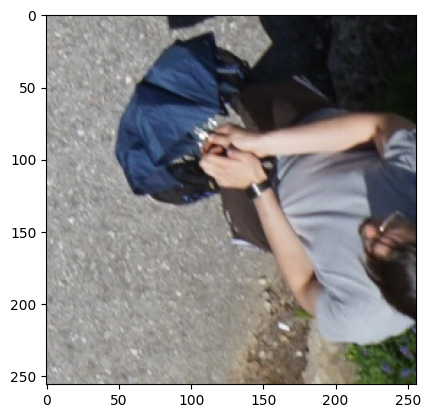

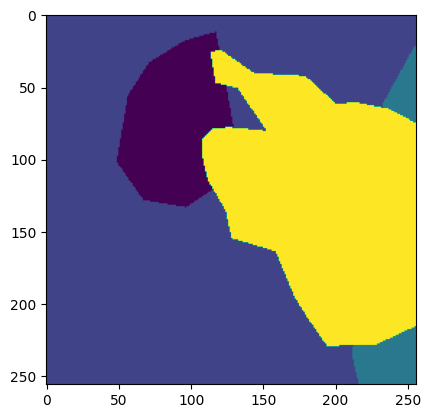

In [5]:
patch_image, patch_mask = dataset[5439]

plt.imshow(patch_image.permute(1, 2, 0))
plt.show()

plt.imshow(patch_mask)
plt.show()

8836


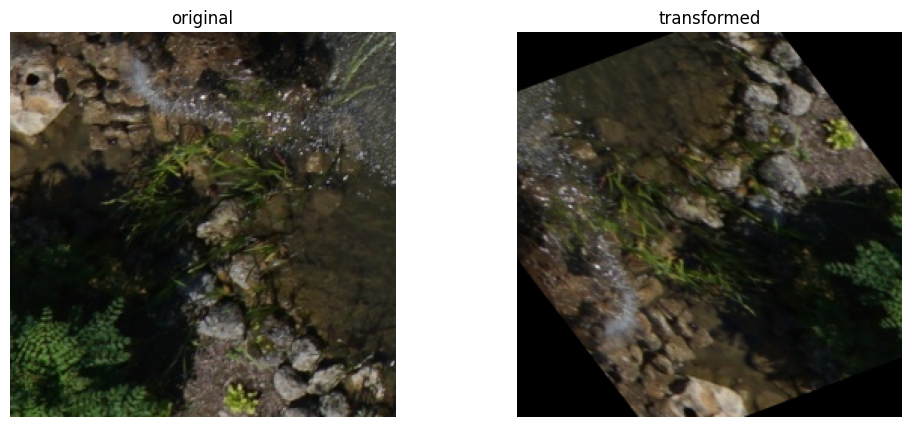

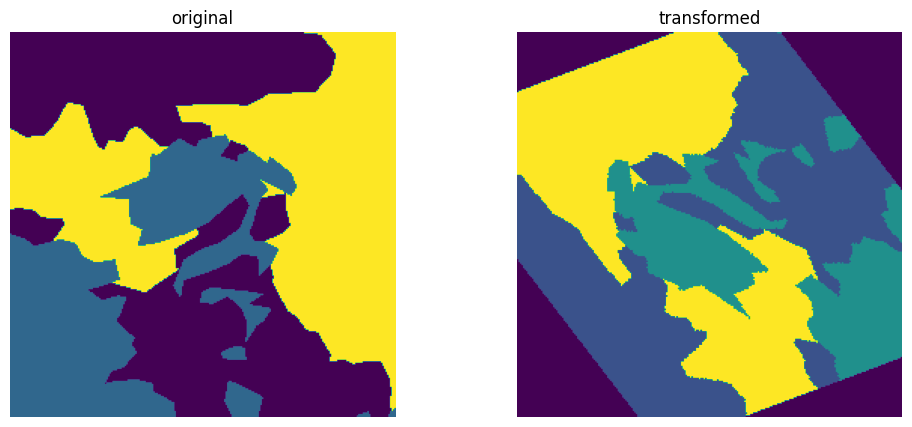

In [81]:
idx = random.randint(0, len(dataset))
print(idx)

patch_image, patch_mask = dataset[idx]

mytransform = A.Affine(
    scale = (0.8, 1.2), # done
    rotate = (-360, 360), # maybe too much but we'll see
    shear = (-20, 20),
    p = 1.0
)

transformed = mytransform(image=patch_image.numpy().transpose(1, 2, 0), mask=patch_mask.numpy())
patch_image_transf = transformed['image']
patch_mask_transf = transformed['mask']
# print(patch_image_transf.sum())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].imshow(patch_image.numpy().transpose(1, 2, 0))
axs[0].set_title('original')
axs[0].axis('off')

axs[1].imshow(patch_image_transf)
axs[1].set_title('transformed')
axs[1].axis('off')

plt.show()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].imshow(patch_mask.numpy())
axs[0].set_title('original')
axs[0].axis('off')

axs[1].imshow(patch_mask_transf)
axs[1].set_title('transformed')
axs[1].axis('off')

plt.show()

In [43]:
torch.unique(patch_mask, return_counts=True)

(tensor([1, 2, 3], dtype=torch.uint8), tensor([14148, 45161,  6227]))

## TRAIN TRANSFORMS

Find adeguate set of transforms and their parameters for this dataset.

In [ ]:
train_transform = A.Compose([
    # Dual transforms
    A.Affine(
        scale = (0.8, 1.2),
        rotate = (-360, 360),
        shear = (-20, 20),
        p = 1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),    
])

In [ ]:
# Add color transforms